## Import required libraries

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree
from dataclasses import replace
import json
# graph representation
import networkx as nx
# GNU linear programming kit (to use GLPK)
import pulp
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.register.register_layout import RegisterLayout
from pulser.devices import MockDevice, AnalogDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, ConstantWaveform, InterpolatedWaveform
from pulser_simulation import SimConfig, QutipEmulator
from pulser.channels.dmm import DMM

## Define Problem Data

### retrieved popuplation

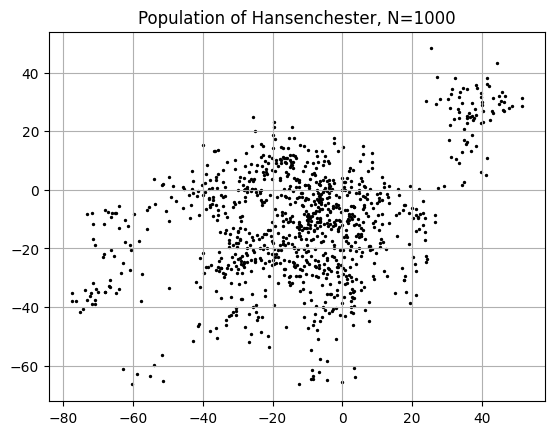

In [106]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)

### Coverage function to maximize

Optimization Function $COV$ for $N$ antennas is given by:

$$
COV = \sum_{i \in N} d_R(i) - B \sum_{i,j \in A} \text{Interfere}(i, j)
$$

where:

$$
\text{Interfere}(i, j) = \begin{cases} 
1, & \text{if } ||\vec{r}_i - \vec{r}_j|| < 2R \\
0, & \text{otherwise}
\end{cases}
$$

with
- coverage radius $R$ = 25
- antenna position $\vec{r}_i$
- $d_R(i)$ the nb. of population points within radius R around $\vec{r}_i$
- interference for $d < 2R$
- maximum nb. of antennas = 70
- minimum coverage = 0.7 $\times$ #population


In [107]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost

### Generate the grid

In [108]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

### Define the problem parameters

In [109]:
# Parameters in rad/µs and ns
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

R_antennas = 25
R_interatomic = AnalogDevice.rydberg_blockade_radius(U)
factor_R_to_Rb = R_antennas/R_interatomic

print('R_interatomic', R_interatomic)
print('factor_R_to_Rb', factor_R_to_Rb)

R_interatomic 7.186760677748386
factor_R_to_Rb 3.478618688027957


In [110]:
# Problem Parameters
population_x = x/factor_R_to_Rb # x coordinates of the population
population_y = y/factor_R_to_Rb # y coordinates of the population
R_antennas = 25/factor_R_to_Rb  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required
# Grid Parameters
spacing = 2*R_antennas  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points


Calculate the coverage at each point of the grid

In [111]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[population_x[i], population_y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

Plot the coverage map

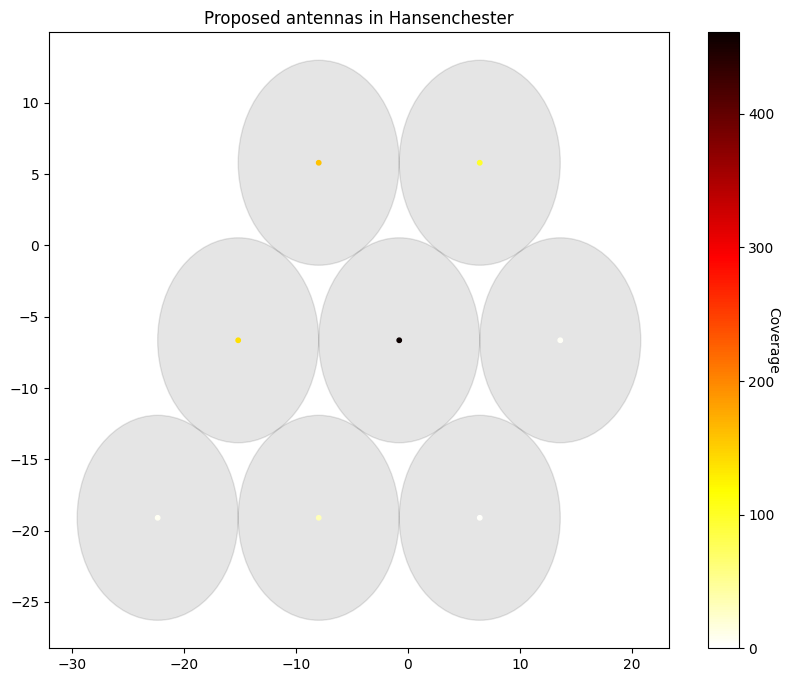

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if z_coverage[ind] > 1e-3:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

{0: Text(-22.331738892979324, -19.102136629460496, '0'),
 1: Text(-7.958217537482552, -19.102136629460496, '1'),
 2: Text(6.41530381801422, -19.102136629460496, '2'),
 4: Text(-0.7714568597341653, -6.654301993762154, '4'),
 3: Text(-15.144978215230939, -6.654301993762154, '3'),
 5: Text(13.602064495762605, -6.654301993762154, '5'),
 8: Text(6.41530381801422, 5.7935326419361886, '8'),
 7: Text(-7.958217537482552, 5.7935326419361886, '7'),
 6: Text(-22.331738892979324, 5.7935326419361886, '6')}

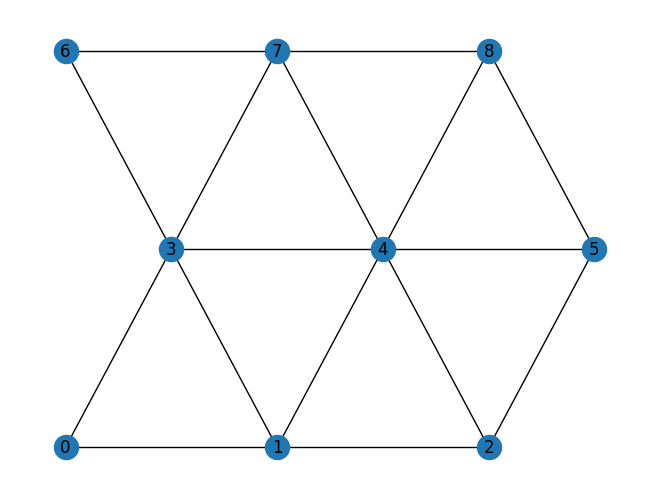

In [113]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

# Pulser Implementation

In [114]:
device_used = MockDevice
seed = 100

In [115]:
t_rise = 800 # ns
t_sweep = 2000
t_fall = 800

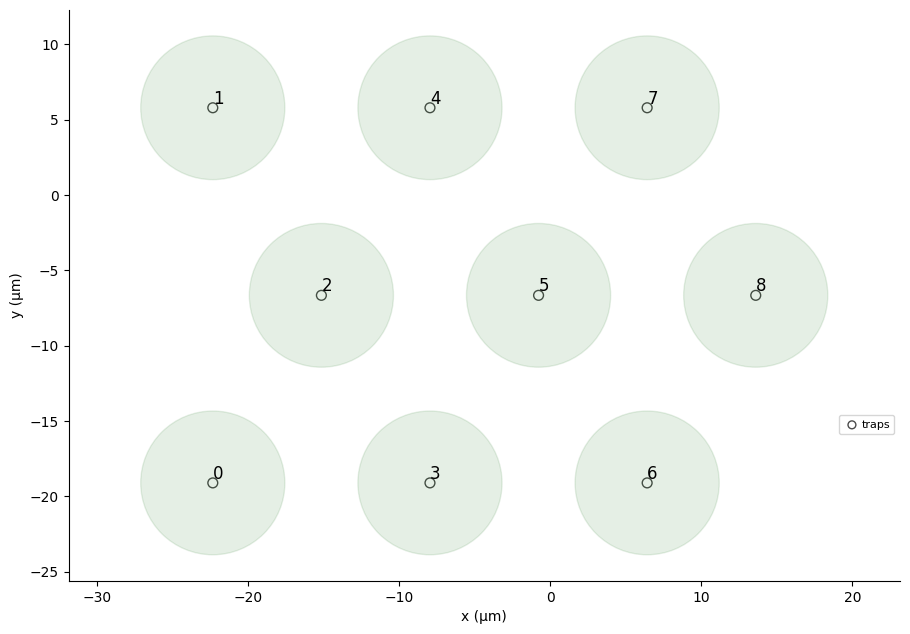

In [116]:
# create a register on NAQC
#qubits = dict(enumerate(np.array(grid_points)/10))
reg = RegisterLayout(np.array(grid_points))
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(R_interatomic),
    draw_graph=True,
    draw_half_radius=True,
)

In [117]:
trap_coordinates = np.array(grid_points)/6
weights = 1 - np.array(z_coverage/np.max(z_coverage))
print(f'Weigths: {weights}')

Weigths: [0.98698482 0.92624729 0.99349241 0.69848156 0.         0.98915401
 1.         0.65509761 0.78741866]


In [118]:
# Apply a logarithmic scaling to normalize the coverage values
# Adding 1 to avoid log(0) in case of 0 coverage
log_scaled_coverage = np.log(np.array(z_coverage) + 1)

# Normalize the log-scaled values between 0 and 1
max_log_coverage = max(log_scaled_coverage)
min_log_coverage = min(log_scaled_coverage)

# Calculate weights: 1 for the lowest coverage and closer to 0 for the highest
if max_log_coverage != min_log_coverage:
    weights = [(max_log_coverage - log_cov) / (max_log_coverage - min_log_coverage) for log_cov in log_scaled_coverage]
else:
    # All antennas have the same coverage; assign a weight of 1
    weights = [1] * len(log_scaled_coverage)

# Print the weights for each antenna
for i, weight in enumerate(weights):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")

Antenna 1: Coverage = 6.0, Weight = 0.68
Antenna 2: Coverage = 34.0, Weight = 0.42
Antenna 3: Coverage = 3.0, Weight = 0.77
Antenna 4: Coverage = 139.0, Weight = 0.19
Antenna 5: Coverage = 461.0, Weight = 0.00
Antenna 6: Coverage = 5.0, Weight = 0.71
Antenna 7: Coverage = 0.0, Weight = 1.00
Antenna 8: Coverage = 159.0, Weight = 0.17
Antenna 9: Coverage = 98.0, Weight = 0.25


In [119]:
# Calculate inverse-based weights
inverse_scaled_coverage = [1 / (coverage + 1) for coverage in z_coverage]  # +1 to handle zero coverage

# Normalize the inverse-scaled values between 0 and 1
max_inverse = max(inverse_scaled_coverage)
min_inverse = min(inverse_scaled_coverage)

if max_inverse != min_inverse:
    weights = [(inv_cov - min_inverse) / (max_inverse - min_inverse) for inv_cov in inverse_scaled_coverage]
else:
    weights = [1] * len(inverse_scaled_coverage)

# Print the weights for each antenna
for i, weight in enumerate(weights):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")


Antenna 1: Coverage = 6.0, Weight = 0.14
Antenna 2: Coverage = 34.0, Weight = 0.03
Antenna 3: Coverage = 3.0, Weight = 0.25
Antenna 4: Coverage = 139.0, Weight = 0.00
Antenna 5: Coverage = 461.0, Weight = 0.00
Antenna 6: Coverage = 5.0, Weight = 0.16
Antenna 7: Coverage = 0.0, Weight = 1.00
Antenna 8: Coverage = 159.0, Weight = 0.00
Antenna 9: Coverage = 98.0, Weight = 0.01


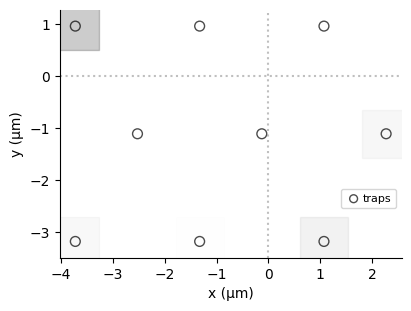

In [120]:
register = Register.from_coordinates(
    trap_coordinates, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights[i] for i in range(len(weights))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw()

In [121]:
dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
    total_bottom_detuning=-2 * np.pi * 2000,  # total detuning
)
mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)
print(mock_device.dmm_channels)

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg'), 'dmm_1': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 1 ns, Minimum pulse duration: 1 ns, Maximum pulse duration: 100000000 ns, Basis: 'ground-rydberg')}


In [122]:
seq = Sequence(register, mock_device)
seq.config_detuning_map(det_map_from_reg, "dmm_0")
print(seq.declared_channels)

total_duration = t_rise + t_sweep + t_fall
waveform = ConstantWaveform(total_duration, -delta_f/5)

# Concatenate the waveforms
seq.add_dmm_detuning(waveform, "dmm_0")
seq.draw(draw_detuning_maps=True)

ValueError: The minimal distance between atoms in this device (5 µm) is not respected (up to a precision of 1e-6 µm) for the pairs: [('q0', 'q1'), ('q0', 'q2'), ('q0', 'q3'), ('q0', 'q4'), ('q0', 'q6'), ('q0', 'q7'), ('q1', 'q2'), ('q1', 'q3'), ('q1', 'q4'), ('q1', 'q5'), ('q1', 'q6'), ('q1', 'q7'), ('q1', 'q8'), ('q2', 'q3'), ('q2', 'q4'), ('q2', 'q5'), ('q2', 'q7'), ('q2', 'q8'), ('q3', 'q4'), ('q3', 'q5'), ('q3', 'q6'), ('q3', 'q7'), ('q3', 'q8'), ('q4', 'q5'), ('q4', 'q6'), ('q4', 'q7'), ('q4', 'q8'), ('q5', 'q7'), ('q5', 'q8'), ('q6', 'q7'), ('q6', 'q8'), ('q7', 'q8')]

In [66]:
# set pulse
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0,
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0,
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0,
)

In [67]:
seq.declare_channel("ryd_glob", "rydberg_global")

In [68]:
print(seq.declared_channels)
seq.add(rise, 'ryd_glob', "no-delay")
seq.add(sweep, 'ryd_glob', "no-delay")
seq.add(fall, 'ryd_glob', "no-delay")

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg'), 'ryd_glob': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 12.566370614359172 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 100000000 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg')}


ValueError: The pulse's amplitude goes over the maximum value allowed for the chosen channel.

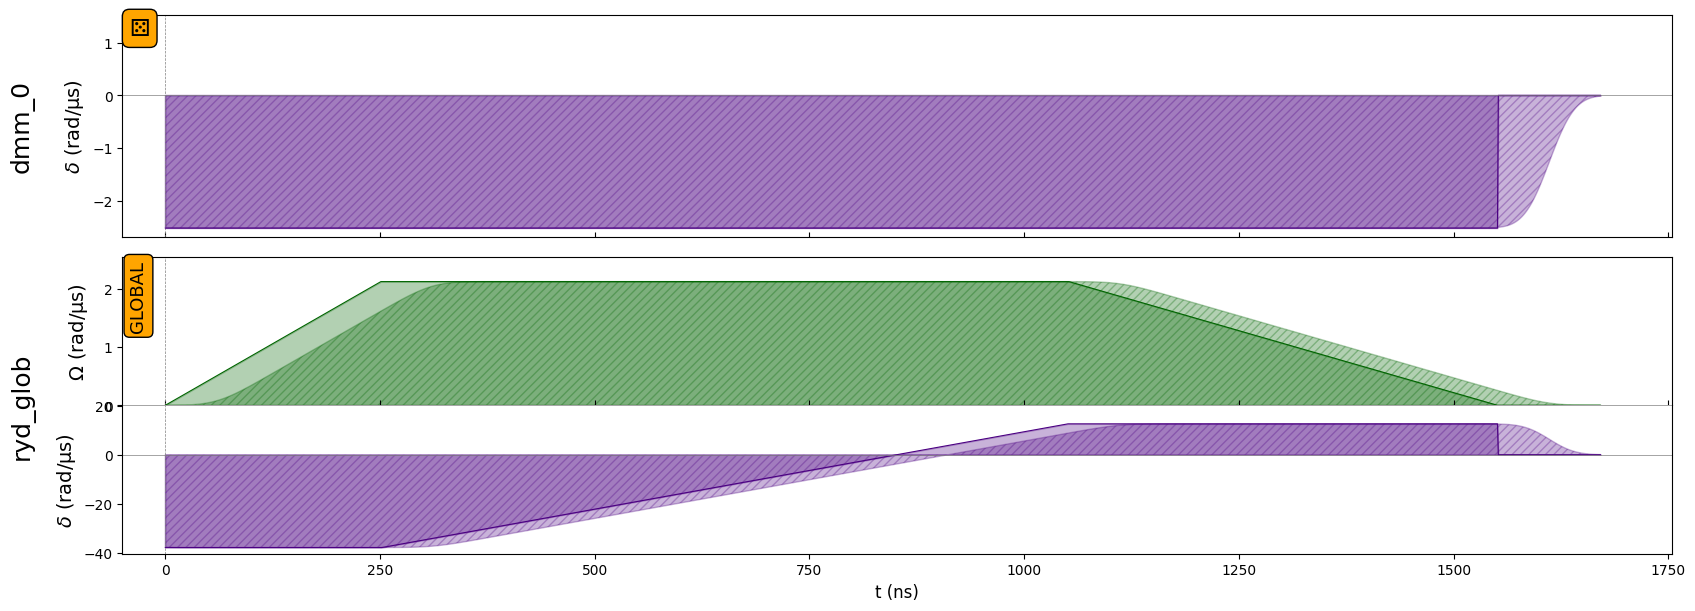

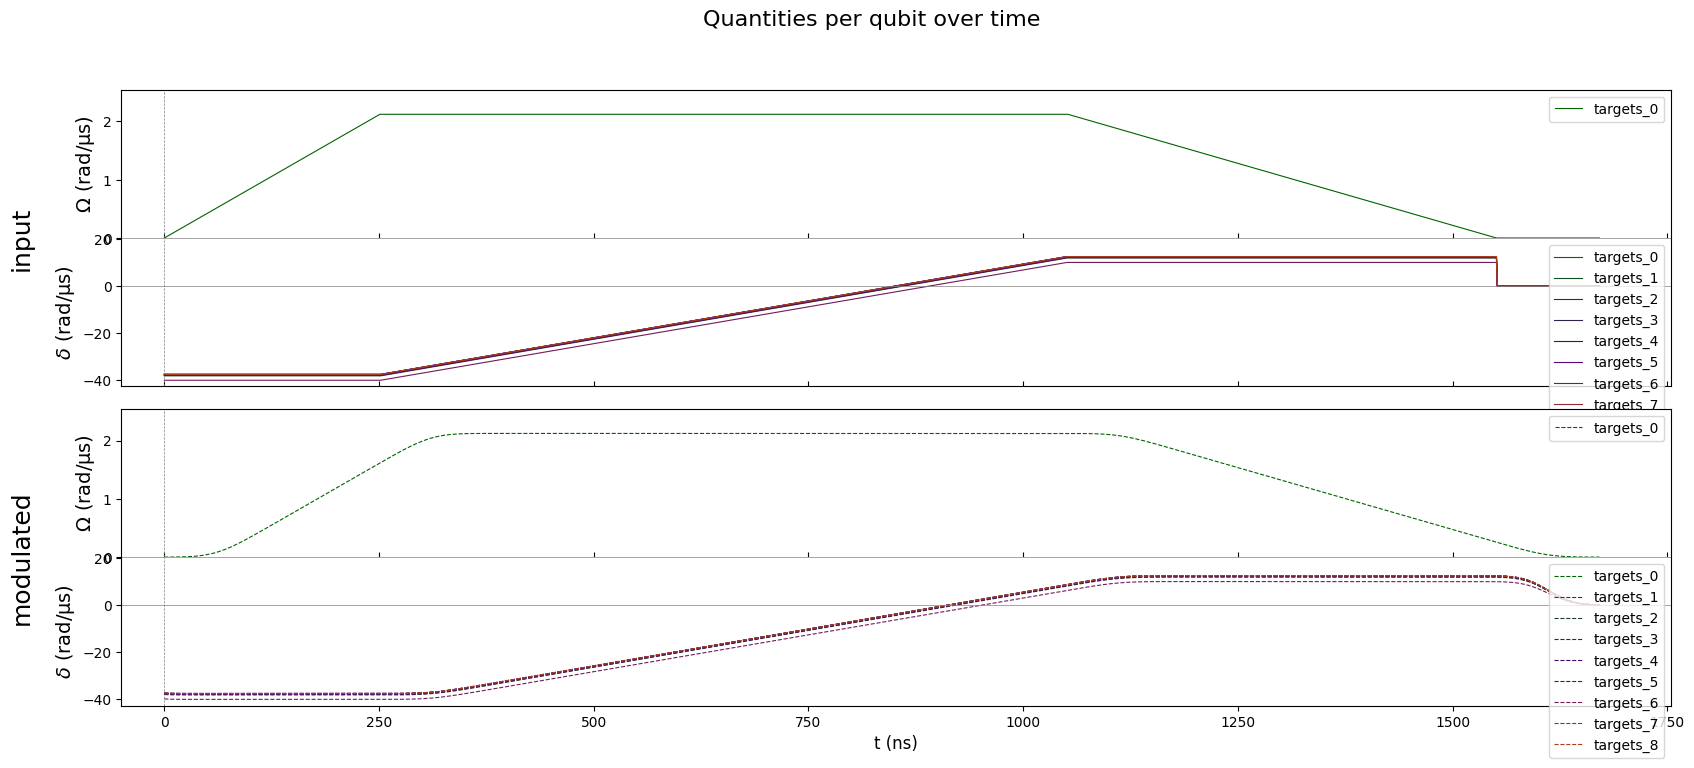

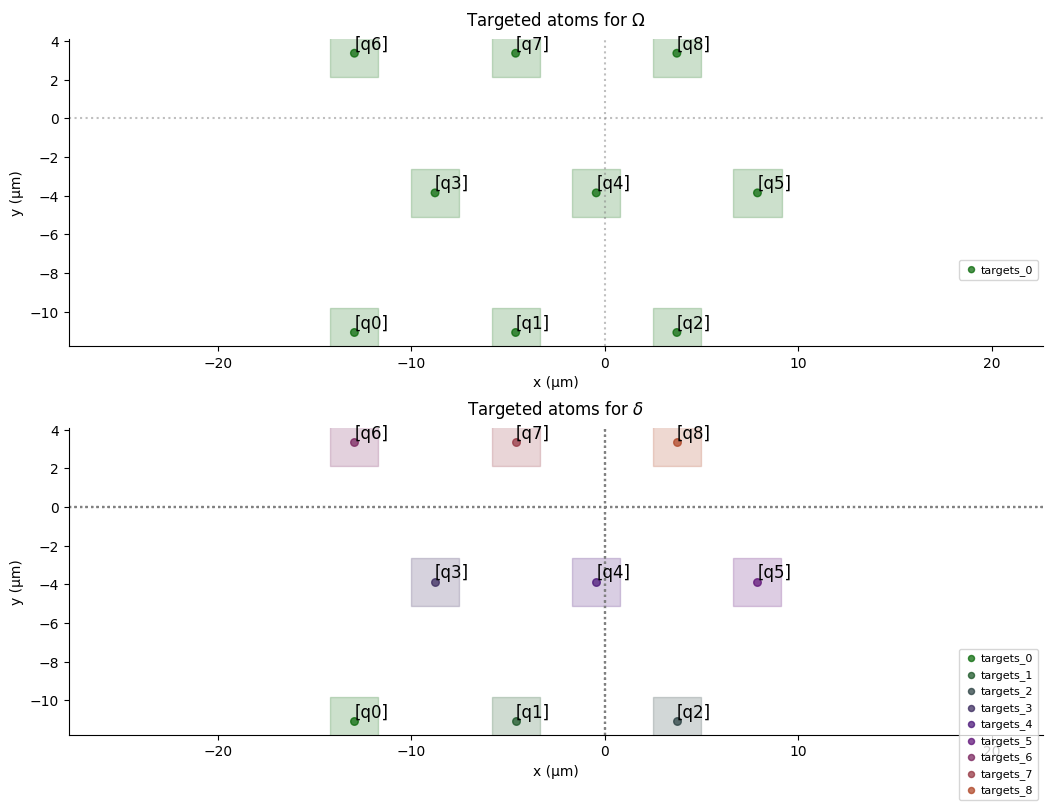

In [433]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

In [434]:
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [435]:
simulator = QutipEmulator.from_sequence(
    seq, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=1000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.26s. Est. time left: 00:00:00:01
30.0%. Run time:   0.39s. Est. time left: 00:00:00:00
40.1%. Run time:   0.50s. Est. time left: 00:00:00:00
50.0%. Run time:   0.64s. Est. time left: 00:00:00:00
60.0%. Run time:   0.77s. Est. time left: 00:00:00:00
70.1%. Run time:   0.94s. Est. time left: 00:00:00:00
80.0%. Run time:   1.12s. Est. time left: 00:00:00:00
90.0%. Run time:   1.30s. Est. time left: 00:00:00:00
Total run time:   1.46s


In [436]:
most_frequent = {k:v for k,v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

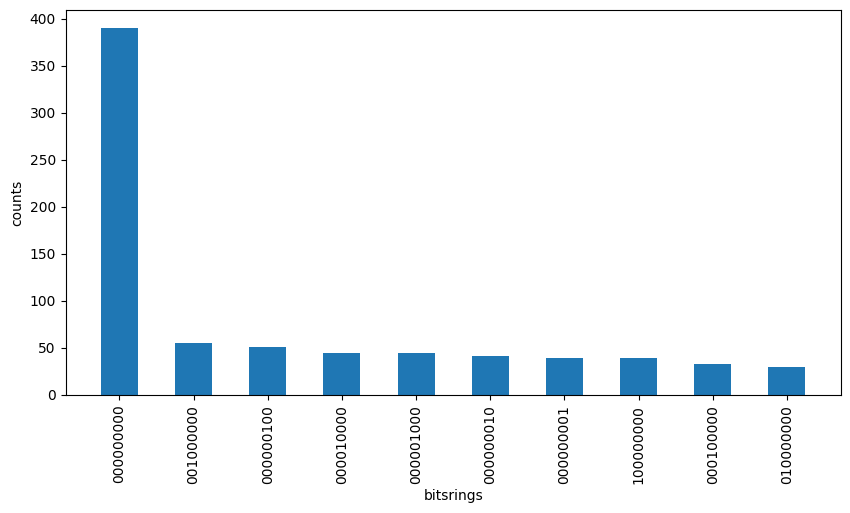

In [437]:
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

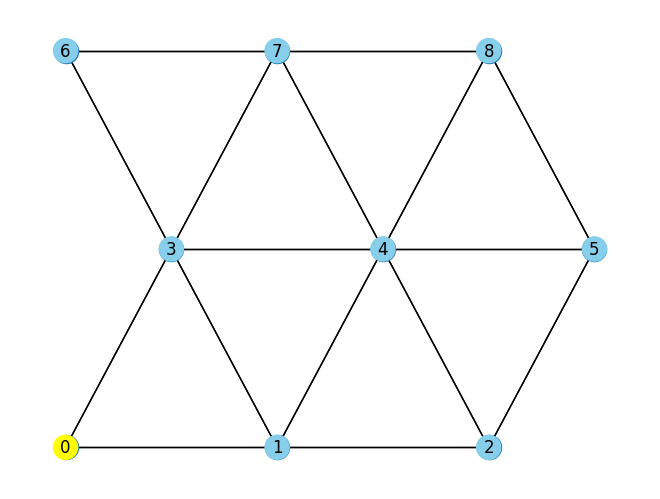

In [440]:
# Sort the bitstrings in descending order
solution = sorted(most_frequent, reverse=True)

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Convert the bitstrings to lists of node indices and select the top 5
solution_indices = [convert_to_indices(res) for res in solution]
top_5 = solution_indices[:5]

# Calculate the total weight (sum of node indices) for each set in the top 5
val_list = [sum(node_set) for node_set in top_5]

# Find the index of the set with the maximum total weight
ind_max = np.argmax(val_list)

# Draw the graph with colored nodes
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

color = []
for i in solution[0]:
    if i == "1":
        color.append('yellow')
    else:
        color.append('skyblue')

nx.draw(graph, pos=grid_points, node_color=color)